In [89]:
# Reading the CSV files and displaying them in dataframes.
import pandas as pd
df2010 = pd.read_csv('https://raw.githubusercontent.com/EvaFlorensa/CatalanNameGenerator/main/Noms_2010-19.csv')
df1940 = pd.read_csv('https://raw.githubusercontent.com/EvaFlorensa/CatalanNameGenerator/main/Noms_1940-49.csv')

In [90]:
# Function for getting the names from the dataframe and pre-processing them.
def get_names(df):
  column_names = df['Sexe'].values # Accessign the column with the names and getting the values in an array.
  names = [str(name) for name in column_names.tolist()] # Changing the names from the array into a list to work with them.
  split_names = [name.split('/') for name in names] # Splitting the names that contain a slash (/) into two. The result is a list of lists.
  noms = [name for lst in split_names for name in lst] # Changing from a list of lists to a list of strings.
  noms = [name.lower() for name in noms] # Putting all the names in lowercase.
  return(noms)

In [91]:
# getting the names from the period 2010-2019.
noms2010 = get_names(df2010)
len(noms2010)

8429

In [33]:
# Packages needed for building the character-based language model.
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [34]:
# Building the vocabulary of characters and mapping them to integers.
chars = sorted(list(set(''.join(noms2010))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: '·', 29: 'à', 30: 'á', 31: 'ç', 32: 'è', 33: 'é', 34: 'í', 35: 'ï', 36: 'ò', 37: 'ó', 38: 'ú', 39: 'ü', 0: '.'}


In [62]:
block_size = 3 # Context length of characters that we will use to predict the next one.

# Function for building the dataset that we will use in our model.
def build_dataset(names):
  X, Y = [], []
  for w in names:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# Building the dataset of the period 2010-2019.
import random
random.seed(42)
random.shuffle(noms2010)
n1 = int(0.8*len(noms2010))
n2 = int(0.9*len(noms2010))

Xtr, Ytr = build_dataset(noms2010[:n1])
Xdev, Ydev = build_dataset(noms2010[n1:n2])
Xte, Yte = build_dataset(noms2010[n2:])

torch.Size([58064, 3]) torch.Size([58064])
torch.Size([7270, 3]) torch.Size([7270])
torch.Size([7325, 3]) torch.Size([7325])


In [63]:
# Creating the parameters for the language model.
g = torch.Generator().manual_seed(2147483647) # The number is for reproducibility.
C = torch.randn((40, 10), generator=g) # 40 tokens (one per character in our vocabulary), 10 dimensions
W1 = torch.randn((30, 200), generator=g) # Weights layer 1.
b1 = torch.randn(200, generator=g) # Bias layer 1.
W2 = torch.randn((200, 40), generator=g) # Weights layer 2.
b2 = torch.randn(40, generator=g) # Bias layer 2.
parameters = [C, W1, b1, W2, b2]

In [64]:
sum(p.nelement() for p in parameters) # Total number of parameters that will be used.

14640

In [65]:
for p in parameters:
  p.requires_grad = True

In [66]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [67]:
# Setting empty lists to keep track of the learning process of the model.
lri = []
lossi = []
stepi = []

In [68]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.0001
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.7216938734054565


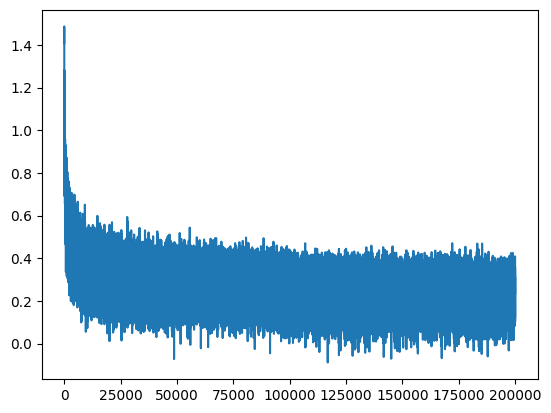

In [69]:
plt.plot(stepi, lossi)

In [70]:
# Calculating training loss.
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.7255, grad_fn=<NllLossBackward0>)

In [71]:
# Calculating validation loss.
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0688, grad_fn=<NllLossBackward0>)

In [72]:
# Function for getting a sample of generated names.
def generate_names(num_names):
    generated_names = []
    g = torch.Generator().manual_seed(2147483647 + 10)

    for _ in range(num_names):
        out = []
        context = [0] * block_size
        while True:
            emb = C[torch.tensor([context])]
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        generated_name = ''.join(itos[i] for i in out)
        generated_names.append(generated_name)

    return generated_names

# Generated names for the period 2010-2019.
names2010_generated = generate_names(20)
names2010_generated

['ashleyla maria.',
 'lucas josé.',
 'sukrisaf.',
 'mil.',
 'àngel fer.',
 'hillopo.',
 'maria.',
 'muri.',
 'maría samuel dana.',
 'rica.',
 'yiharlos josé.',
 'noskiroima.',
 'ther.',
 'alan carwi.',
 'iteldar.',
 'junia.',
 'remy danie.',
 'muhammateo.',
 'aina.',
 'itz.']

In [87]:
# Function to assess quality, by counting how many of the generated names exist in reality:
def assess_quality(generated_names, real_names):
    existing_names = [word for word in generated_names if word[:-1] in real_names] # Checking if the generated names are in the list of real names.
    existing_count = len(existing_names)
    # Calculating the percentage of existing words:
    total_count = len(generated_names)
    existing_percentage = (existing_count / total_count) * 100

    return existing_percentage, existing_names

# Quality of the generated names of the period 2010-2019:
assess_quality(names2010_generated, noms2010)

(20.0, ['lucas josé.', 'maria.', 'junia.', 'aina.'])

## Now, let's apply the model to the second period of time (1940-1949):

In [74]:
# First, we obtain the names from the dataset with the function get_names.
noms1940 = get_names(df1940)
len(noms1940)

3854

In [75]:
# Then we build the dataset for the second period.
random.seed(42)
random.shuffle(noms1940)
n3 = int(0.8*len(noms1940))
n4 = int(0.9*len(noms1940))

Xtr2, Ytr2 = build_dataset(noms1940[:n3])
Xdev2, Ydev2 = build_dataset(noms1940[n3:n4])
Xte2, Yte2 = build_dataset(noms1940[n4:])

torch.Size([31614, 3]) torch.Size([31614])
torch.Size([3969, 3]) torch.Size([3969])
torch.Size([3899, 3]) torch.Size([3899])


In [76]:
# Restarting the lists for the training process.
lri2 = []
lossi2 = []
stepi2 = []

In [77]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr2.shape[0], (32,))

  # forward pass
  emb = C[Xtr2[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 40)
  loss = F.cross_entropy(logits, Ytr2[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.0001
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi2.append(i)
  lossi2.append(loss.log10().item())

print(loss.item())

0.9245763421058655


In [78]:
# Calculating training loss.
emb = C[Xtr2] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr2)
loss

tensor(1.3046, grad_fn=<NllLossBackward0>)

In [79]:
# Calculating validation loss.
emb = C[Xdev2] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev2)
loss

tensor(1.7396, grad_fn=<NllLossBackward0>)

In [80]:
# Sample of generated names for the period 1940-1941.
names1940_generated = generate_names(20)
names1940_generated

['maría la maria.',
 'luc.',
 'maria.',
 'del riticiane.',
 'àngel rosa.',
 'geno.',
 'mohans josé.',
 'valèria.',
 'abundo enmirena.',
 'nicarlos santina.',
 'juan marta maria de la pila.',
 'dor.',
 'juan josefina.',
 'irme enrique.',
 'taida.',
 'ino.',
 'miguel rosanda.',
 'melcho.',
 'pedro.',
 'agustín.']

In [88]:
# Assessing quality of the names generated for the period 1940-1941.
assess_quality(names1940_generated, noms1940)

(20.0, ['maria.', 'valèria.', 'pedro.', 'agustín.'])